# Chapter 6 文書のクラスタリング

In [1]:
import common_func as cf

In [2]:
# 日本語フォントの設定
import matplotlib.font_manager as fm
from matplotlib import rcParams

japanese_font_candidates = ['Hiragino Maru Gothic Pro','Yu Gothic',
                            'Arial Unicode MS','Meirio','Takao',
                            'IPAexGothic','IPAPGothic','VL PGothic',
                            'Noto Sans CJK JP']

def get_japanese_fonts(candidates=japanese_font_candidates):
    fonts = []
    for i in fm.findSystemFonts():
        p = fm.FontProperties(fname=f)
        try:
            n = p.get_name()
            if n in candidates:
                fonts.append(f)
        except RuntimeError:
            pass
    # サンプルデータアーカイブに含まれているIPAexフォントを追加する
    fonts.append('irpb-files/font/ipaexg.ttf')
    return fonts

def configure_fonts_for_japanese(fonts=japanese_font_candidates):
    if hasattr(fm.fontManager,'addfont'):
        fm.fontManager.addfont('irpb-files/font/ipaexg.ttf')
    else:
        ipa_font_files = fm.findSystemFonts(fontpaths='font')
        ipa_font_list = fm.createFontList(ipa_font_files)
        fm.fontManager.ttflist.extend(ipa_font_list)
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = fonts


## 6.1 k平均法

In [3]:
# 書籍紹介の文書ベクトルを作成する。

# 書籍の紹介文の読み込み
book_texts = [cf.get_string_from_file('irpb-files/data/ch06/%d.txt' % i) for i in range(12)]

# 特徴語の重みを計算して文書ベクトルを作成する。
# 補助的なコーパスとして青空文庫を利用する。
tfidf_model,dic,vectors = cf.get_tfidfmodel_and_weights(book_texts)

# 書籍のタイトルを読み込む
titles = cf.get_list_from_file('irpb-files/data/ch06/book-titles.txt')

# k平均法による文書のクラスタリング
from gensim import matutils
import numpy as np
from sklearn.cluster import KMeans

# 0を補ったベクトルに変換する
dense_vectors = matutils.corpus2dense(vectors,len(dic)).T

# k-meansでK(=4)個のクラスタに分類する
K = 4
result = KMeans(n_clusters=K).fit(dense_vectors)
#print(result.labels_)

# クラスタごとに書籍タイトルを表示する
# np.where(l == m)でリストl中のmが出現する位置が得られる
for label in range(K):
    print([titles[i] for i in np.where(result.labels_ == label)[0]])

['風車工学入門', '再生可能エネルギー技術']
['都市景観の環境デザイン', '地球と都市の温暖化', '都市環境から考えるこれからのまちづくり', '都市計画']
['森林水文学', '植物と微気象', '生態系生態学']
['Webアプリケーション構築入門', '自作PCクラスタ超入門', 'やさしい音と音楽のプログラミング']


## 6.2 凝集型階層的クラスタリング

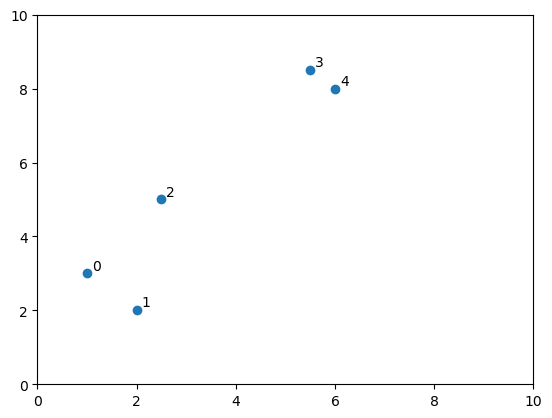

In [4]:
# 平面上の5点の配置
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

data = [[1,3],[2,2],[2.5,5],[5.5,8.5],[6,8]]

# matplotlibのpyplotではデータをx軸、y軸に分けて指定する。
# dataからx軸を取り出す
xlist = [x[0] for x in data]
# dataからy軸を取り出す
ylist = [x[1] for x in data]

# x軸の表示範囲の設定
plt.xlim(0,10)
# y軸の表示範囲の設定
plt.ylim(0,10)

# dataをプロット
plt.scatter(xlist,ylist)

# プロットの位置から(delta,delta)離れたところにデータ番号を表示する。
delta = 0.1
for i,(x,y) in enumerate(zip(xlist,ylist)):
    plt.annotate(str(i),(x + delta,y + delta))


{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [10.0, 10.0, 32.5, 32.5]],
 'dcoord': [[0.0, 0.7071067811865476, 0.7071067811865476, 0.0],
  [0.0, 1.4142135623730951, 1.4142135623730951, 0.0],
  [0.0, 3.1091263510296048, 3.1091263510296048, 1.4142135623730951],
  [0.7071067811865476,
   9.738240771994363,
   9.738240771994363,
   3.1091263510296048]],
 'ivl': ['3', '4', '2', '0', '1'],
 'leaves': [3, 4, 2, 0, 1],
 'color_list': ['C1', 'C2', 'C2', 'C0'],
 'leaves_color_list': ['C1', 'C1', 'C2', 'C2', 'C2']}

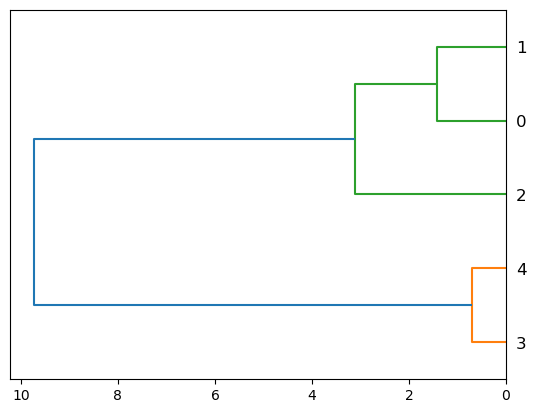

In [31]:
# デンドログラムの作成
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage,dendrogram

data = [[1,3],[2,2],[2.5,5],[5.5,8.5],[6,8]]

# 要素間の距離を計算する
d = pdist(data)

# 群平均法でクラスタリング
L = linkage(d,method='ward')

# 色分けの閾値を４にして横向きにデンドログラムを作成する
threshold = 4
dendrogram(L,orientation='left',color_threshold=threshold)

In [5]:
# クラスタリング結果を取得する
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage,dendrogram,fcluster

data = [[1,3],[2,2],[2.5,5],[5.5,8.5],[6,8]]

d = pdist(data)
L = linkage(d,method='average')

# fclusterは各要素が属するクラスタの番号のリストを返す
# つまり、f[i]はdata[i]が属するクラスタの番号となる
threshold = 4
f = fcluster(L,threshold,criterion='distance')

# dataの要素の番号Iと、それが属するクラスタの番号jを表示する。
for i,j in enumerate(f):
    print('data[%d]: cluster %d' % (i,j))

data[0]: cluster 2
data[1]: cluster 2
data[2]: cluster 2
data[3]: cluster 1
data[4]: cluster 1


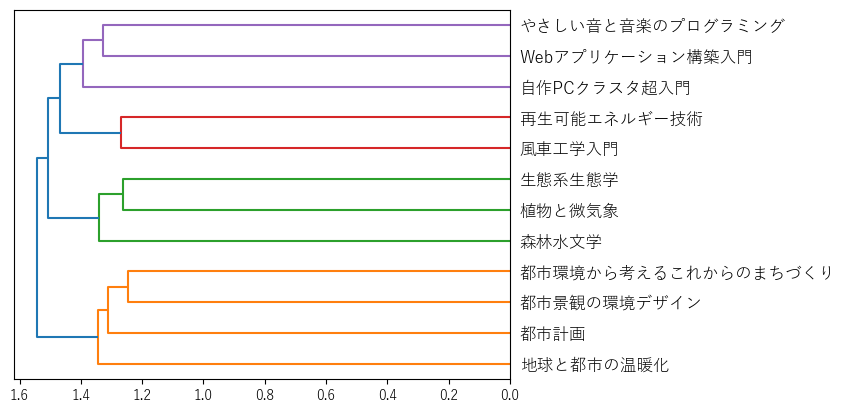

In [6]:
# 文書データのデンドログラムを作成する
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage,dendrogram

# 日本語フォントの設定
configure_fonts_for_japanese()

# 文書ベクトル間の距離を計算する
d = pdist(dense_vectors)

# ウォード法を使う
L = linkage(d,method='ward')
dendrogram(L,labels=titles,color_threshold=1.4,orientation='left');



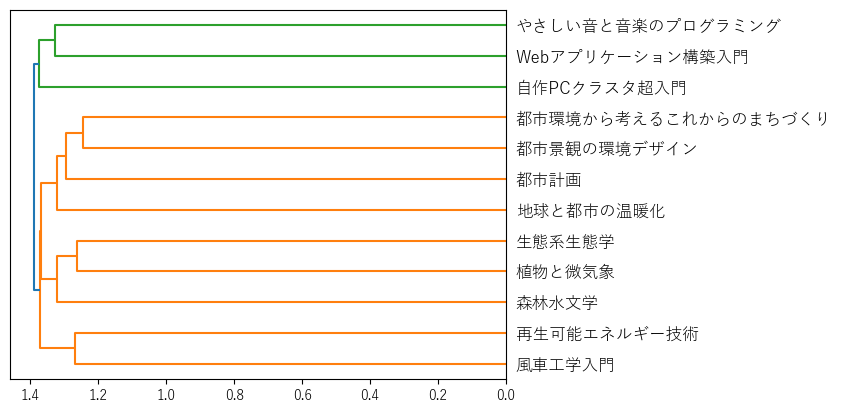

In [7]:
# 群平均法をつかう
P = linkage(d,method='average')
dendrogram(P,labels=titles,color_threshold=1.38,orientation='left');


In [8]:
# コーフェン相関係数の比較
from scipy.cluster.hierarchy import cophenet

d = pdist(dense_vectors)
methods = ['average','centroid','complete','median','single','ward','weighted']

for m in methods:
    L = linkage(d,method=m)
    c = cophenet(L,d)
    # cophenetが返す2つの値のうちの最初の値がコーフェン相関係数
    print('%s\t%7.4f' % (m,c[0]))


average	 0.8871
centroid	-0.5390
complete	 0.8341
median	 0.0012
single	 0.8531
ward	 0.7695
weighted	 0.8834
